In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as mobilenet_preprocess_input
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input as densenet_preprocess_input
from tensorflow.keras.applications.xception import Xception, preprocess_input as xception_preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import warnings
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

In [2]:
y = [1, 1, 1, 1, 0, 0]


In [3]:
# Function to plot ROC Curve and AUC
def plot_roc_curve_and_auc(y_true, y_pred, model_name, n_classes):
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.show()

In [4]:
# Define class names
class_names = [
    'Car', 'Bus', 'Bicycle', 'Ambassador',
    'Van', 'Motorized2wheeler', 'Rickshaw',
    'Motorvan', 'Truck', 'Autorickshaw',
    'Toto', 'MiniTruck'
]

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix', normalize=False):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        cmap = 'Blues'
        plt.title(f'{title} (Normalized)')
    else:
        fmt = 'd'
        cmap = 'Oranges'
        plt.title(f'{title} (Raw Counts)')
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Function to plot training and validation accuracy and loss
def plot_training_history(history, model_name):
    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to build and train a model, and print results
def train_model(base_model_class, preprocess_input_function, model_name, class_names):
    if base_model_class is None:
        print(f"{model_name} is not available in this environment.")
        return
    
    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input_function,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    validation_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input_function
    )

    # Create generators
    train_generator = train_datagen.flow_from_directory(
        '/kaggle/input/vehicle-classification-ds/data/train',
        target_size=(128, 128),
        batch_size=16,
        class_mode='categorical'
    )

    validation_generator = validation_datagen.flow_from_directory(
        '/kaggle/input/vehicle-classification-ds/data/test',
        target_size=(128, 128),
        batch_size=16,
        class_mode='categorical',
        shuffle=False
    )

    # Load the base model
    base_model = base_model_class(weights=None, include_top=False, input_shape=(128, 128, 3))
    
    # Unfreeze the top layers of the base model
    for layer in base_model.layers[-20:]:
        layer.trainable = True
    
    # Build the model
    model = Sequential([
        base_model,
        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(len(class_names), activation='softmax')  # Adjust for the number of classes
    ])
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6)
    model_checkpoint = ModelCheckpoint(f'{model_name}_best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
    
    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        epochs=50,
        callbacks=[early_stopping, model_checkpoint]
    )
    
    # Plot training and validation loss and accuracy
    plot_training_history(history, model_name)
    
    # Predictions
    validation_generator.reset()
    start_time = time.time()
    Y_pred = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
    end_time = time.time()
    t_time = end_time - start_time
    print(f"Prediction time: {t_time} seconds")
    
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = validation_generator.classes
    
    # Classification report and accuracy
    report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    overall_accuracy = accuracy_score(y_true, y_pred)
    overall_precision = report_dict['weighted avg']['precision']
    overall_recall = report_dict['weighted avg']['recall']
    overall_f1_score = report_dict['weighted avg']['f1-score']
    
    print(f"\nModel: {model_name}")
    print(f"Overall Accuracy: {overall_accuracy:.2f}")
    print(f"Overall Precision: {overall_precision:.2f}")
    print(f"Overall Recall: {overall_recall:.2f}")
    print(f"Overall F1-Score: {overall_f1_score:.2f}")
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot raw and normalized confusion matrices
    plot_confusion_matrix(cm, class_names, title=f'{model_name} Confusion Matrix (Raw Counts)', normalize=False)
    plot_confusion_matrix(cm, class_names, title=f'{model_name} Confusion Matrix (Normalized)', normalize=True)
    
    # Convert y_true to one-hot encoding for ROC curve
    y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=len(class_names))

    # ROC Curve and AUC (Function assumed to be defined elsewhere)
    plot_roc_curve_and_auc(y_true_one_hot, Y_pred, model_name, len(class_names))

Found 4357 images belonging to 12 classes.
Found 2055 images belonging to 12 classes.
Epoch 1/50


I0000 00:00:1729533004.442184     103 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_2', 4 bytes spill stores, 4 bytes spill loads



272/272 ━━━━━━━━━━━━━━━━━━━━ 218s 593ms/step - accuracy: 0.3853 - loss: 1.9966 - val_accuracy: 0.1172 - val_loss: 2.6484
Epoch 2/50
  1/272 ━━━━━━━━━━━━━━━━━━━━ 1:12 266ms/step - accuracy: 0.7500 - loss: 1.0962

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7500 - loss: 1.0962 - val_accuracy: 0.0000e+00 - val_loss: 3.3061
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 145s 521ms/step - accuracy: 0.6664 - loss: 1.1147 - val_accuracy: 0.1182 - val_loss: 2.4511
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step - accuracy: 0.6250 - loss: 1.0087 - val_accuracy: 0.0000e+00 - val_loss: 3.1542
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 141s 508ms/step - accuracy: 0.7123 - loss: 0.9287 - val_accuracy: 0.6416 - val_loss: 1.1727
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - accuracy: 0.8125 - loss: 0.7518 - val_accuracy: 1.0000 - val_loss: 0.0604
Epoch 7/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 129s 463ms/step - accuracy: 0.7725 - loss: 0.7956 - val_accuracy: 0.6562 - val_loss: 1.1236
Epoch 8/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step - accuracy: 1.0000 - loss: 0.2207 - val_accuracy: 1.0000 - val_loss: 0.1422
Epoch 9/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 142s 466ms/step - accuracy: 0.8067 - loss: 0.667

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

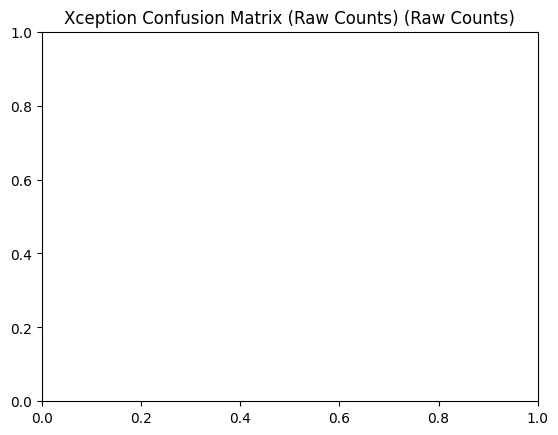

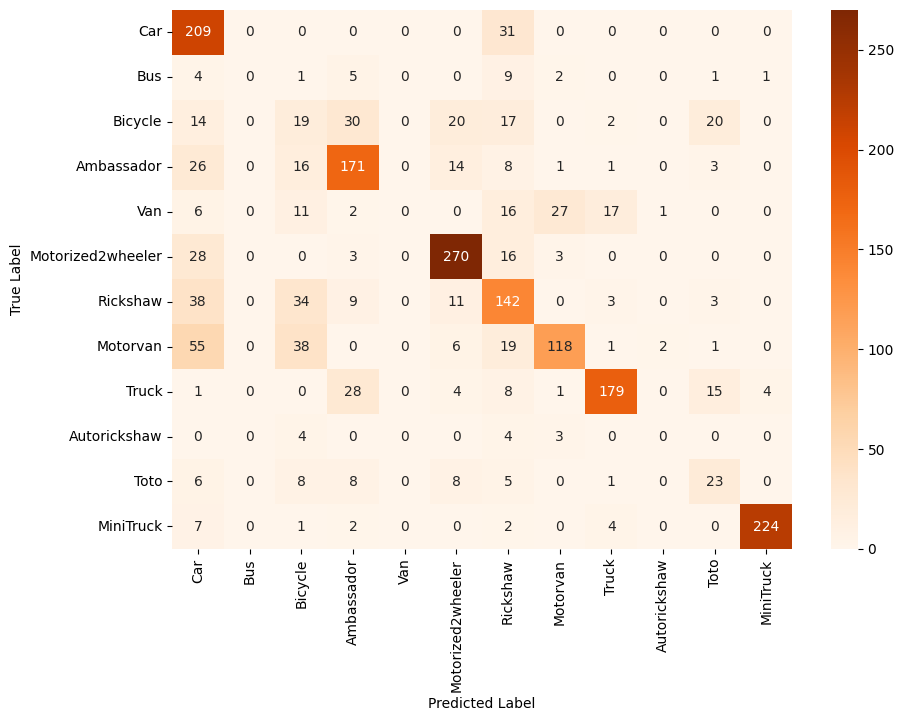

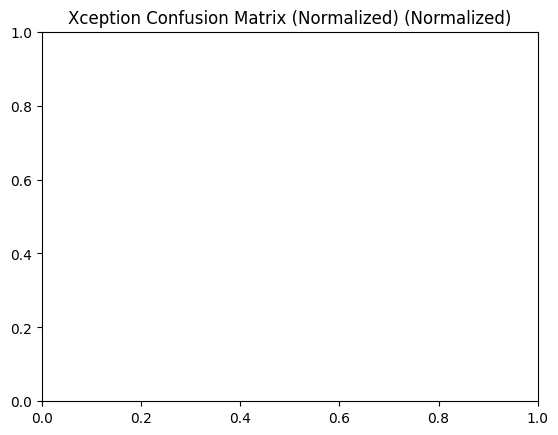

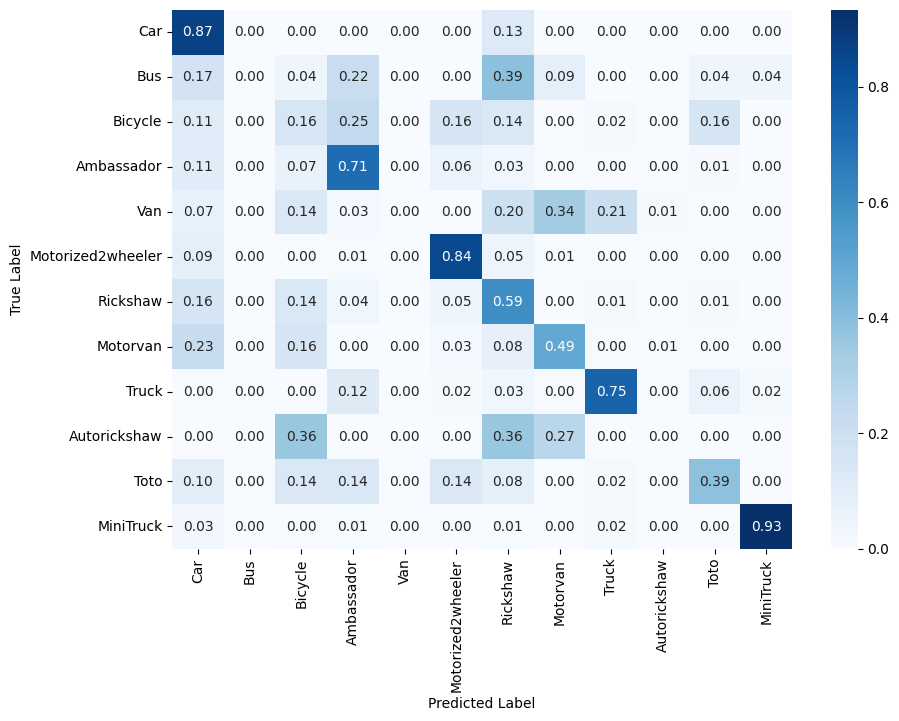

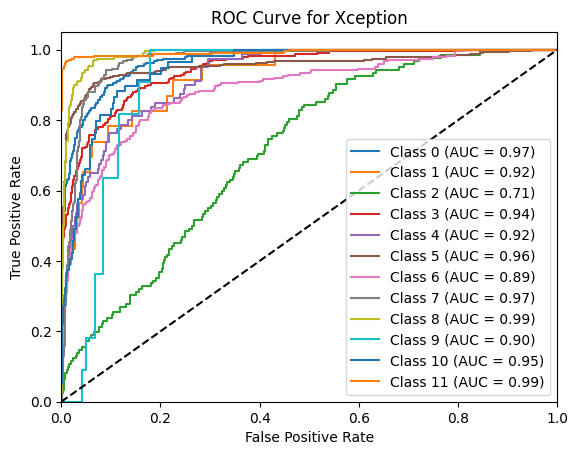

In [14]:
# Train each model separately
train_model(Xception, tf.keras.applications.xception.preprocess_input, 'Xception', class_names)

Found 4357 images belonging to 12 classes.
Found 2055 images belonging to 12 classes.
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729534412.949407     104 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_slice_fusion_1', 4 bytes spill stores, 4 bytes spill loads



 95/272 ━━━━━━━━━━━━━━━━━━━━ 1:14 420ms/step - accuracy: 0.2571 - loss: 2.4416

I0000 00:00:1729534557.514143     103 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_15', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_16', 12 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_17', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_27', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_28', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_39', 12 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fus

272/272 ━━━━━━━━━━━━━━━━━━━━ 408s 902ms/step - accuracy: 0.3646 - loss: 2.0693 - val_accuracy: 0.3877 - val_loss: 1.9873
Epoch 2/50
  1/272 ━━━━━━━━━━━━━━━━━━━━ 51s 190ms/step - accuracy: 0.6875 - loss: 1.1060

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


272/272 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 0.6875 - loss: 1.1060 - val_accuracy: 0.4286 - val_loss: 1.7186
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 136s 490ms/step - accuracy: 0.6532 - loss: 1.2090 - val_accuracy: 0.5303 - val_loss: 1.5609
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.5000 - loss: 1.5271 - val_accuracy: 0.8571 - val_loss: 0.4733
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 131s 469ms/step - accuracy: 0.7120 - loss: 1.0231 - val_accuracy: 0.6382 - val_loss: 1.2611
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6875 - loss: 1.1927 - val_accuracy: 1.0000 - val_loss: 0.0805
Epoch 7/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 130s 468ms/step - accuracy: 0.7394 - loss: 0.8998 - val_accuracy: 0.5078 - val_loss: 1.7928
Epoch 8/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6875 - loss: 1.0812 - val_accuracy: 1.0000 - val_loss: 0.0364
Epoch 9/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 131s 471ms/step - accuracy: 0.7673 - loss: 0.8068 - val_a

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

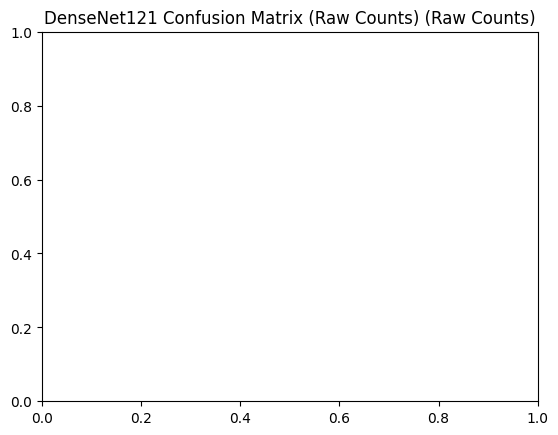

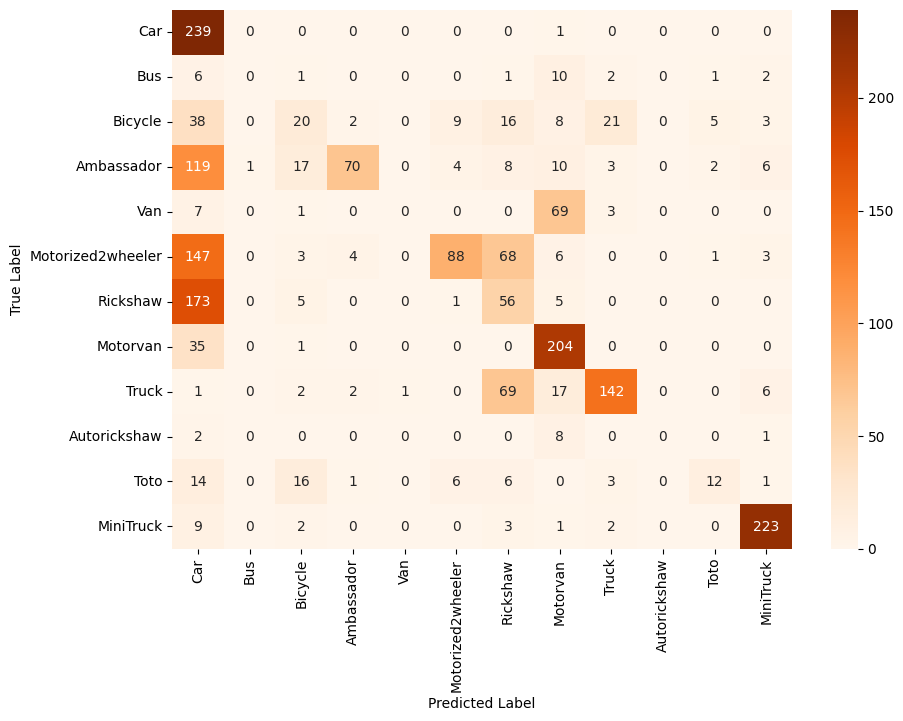

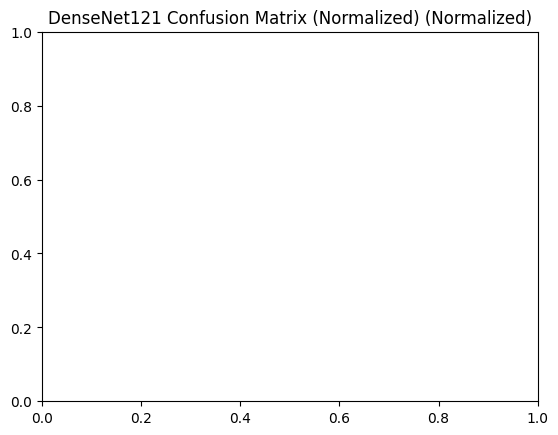

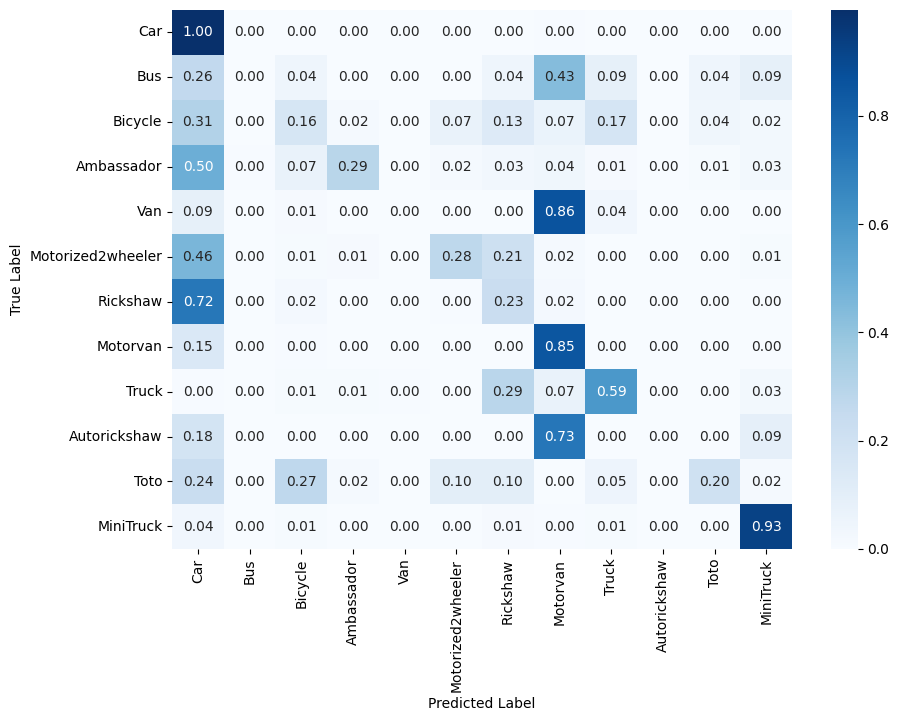

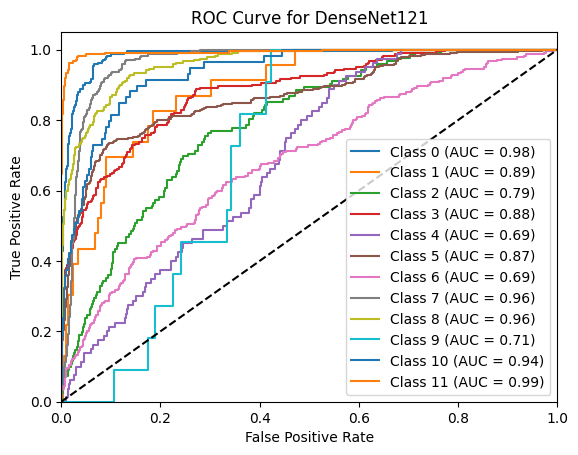

In [15]:
train_model(DenseNet121, tf.keras.applications.densenet.preprocess_input, 'DenseNet121',class_names)

Found 4357 images belonging to 12 classes.
Found 2055 images belonging to 12 classes.
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


272/272 ━━━━━━━━━━━━━━━━━━━━ 249s 625ms/step - accuracy: 0.2748 - loss: 2.3160 - val_accuracy: 0.1172 - val_loss: 3.1712
Epoch 2/50
  1/272 ━━━━━━━━━━━━━━━━━━━━ 41s 153ms/step - accuracy: 0.6250 - loss: 1.4496

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


272/272 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6250 - loss: 1.4496 - val_accuracy: 0.0000e+00 - val_loss: 4.3387
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 203s 564ms/step - accuracy: 0.5651 - loss: 1.4178 - val_accuracy: 0.4922 - val_loss: 1.6267
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.5625 - loss: 1.3439 - val_accuracy: 0.5714 - val_loss: 0.8054
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 128s 458ms/step - accuracy: 0.6430 - loss: 1.1999 - val_accuracy: 0.5195 - val_loss: 1.6553
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - accuracy: 0.6250 - loss: 1.0451 - val_accuracy: 0.8571 - val_loss: 0.9145
Epoch 7/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 127s 457ms/step - accuracy: 0.6537 - loss: 1.1459 - val_accuracy: 0.4893 - val_loss: 2.3322
Epoch 8/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.6250 - loss: 1.0600 - val_accuracy: 1.0000 - val_loss: 7.8096e-04
Epoch 9/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 127s 457ms/step - accuracy: 0.6725 - loss: 1.0890

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

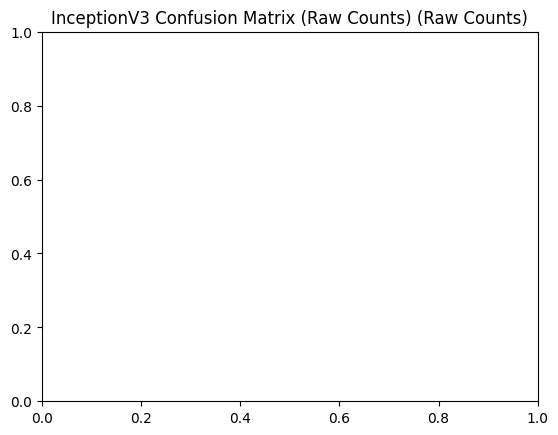

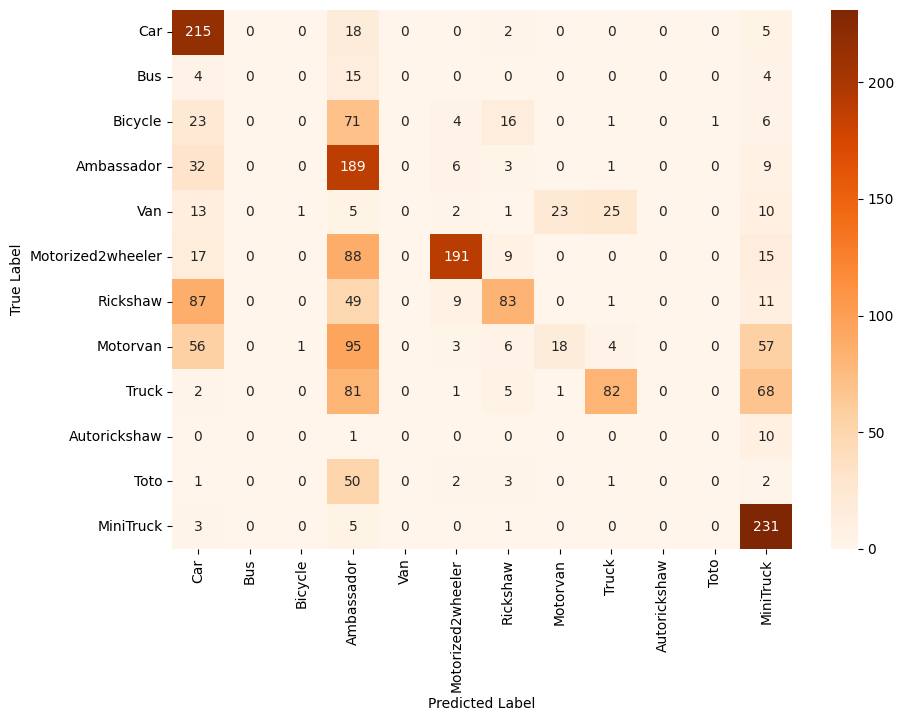

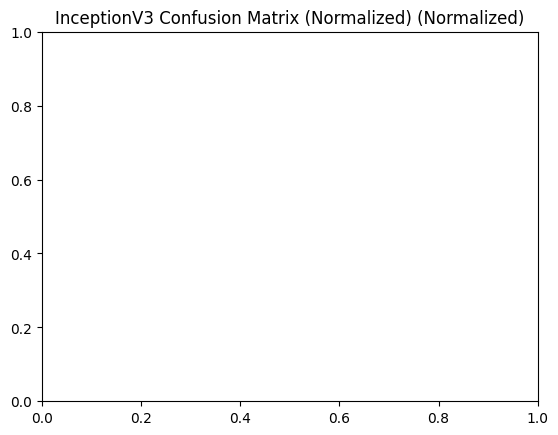

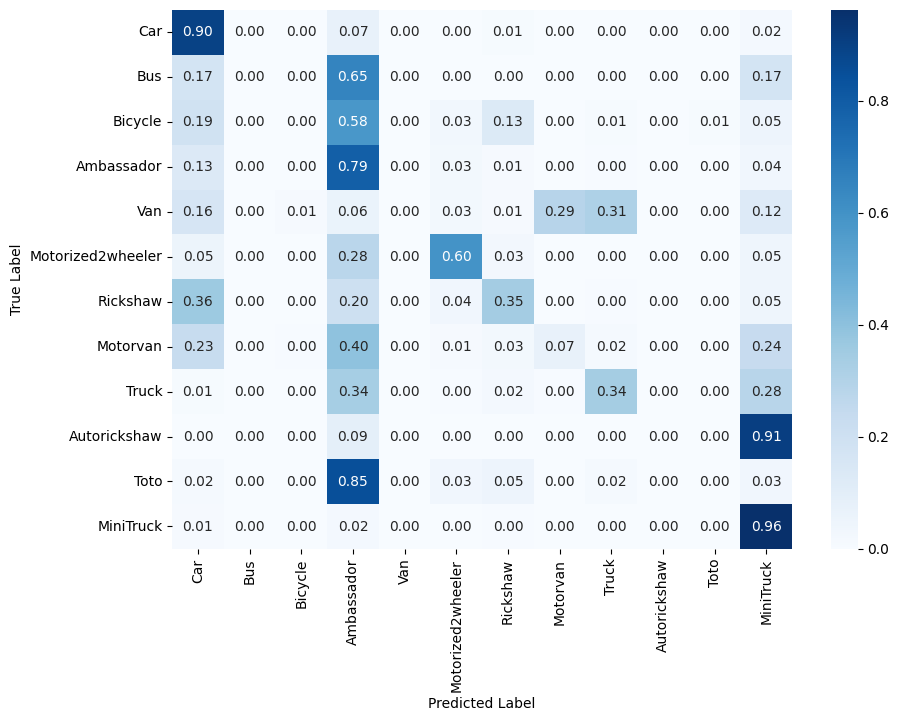

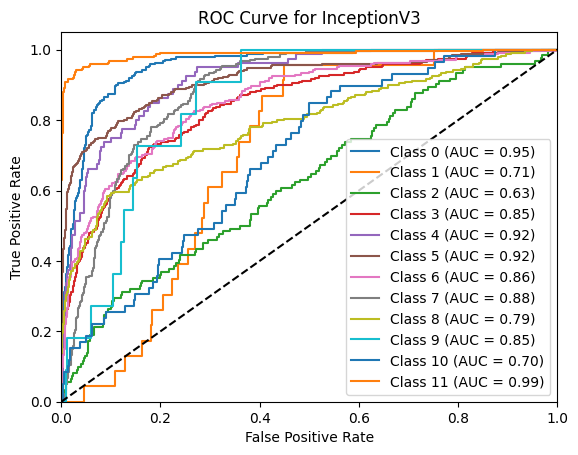

In [16]:
train_model(InceptionV3, tf.keras.applications.inception_v3.preprocess_input, 'InceptionV3',class_names)